In [1]:
import fastai
fastai.__version__

'2.7.5'

In [2]:
#|export
from __future__ import annotations
from fastai.basics import *
from fastai.tabular.core import *
from fastai.tabular.model import *
from fastai.tabular.data import *
from fastai.tabular.all import *

/home/fabio/Documents/tabular_lesion/env_tabular/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


In [3]:
!pwd

/home/fabio/Documents/tabular_lesion


In [4]:
data_path = os.path.join(os.getcwd(), 'data')
data_path

'/home/fabio/Documents/tabular_lesion/data'

In [5]:
import os

import pandas as pd
import sklearn
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline, FeatureUnion

from helpers.dataset import DataSet
from helpers.variance import DataVariance
from helpers.roc_curve import RocCurve
from helpers.validation import ModelValidation
from helpers.model_save import XgboostModelToOnnx

In [6]:
all_set = DataSet(os.path.join(data_path, 'lesion_df_balanced_Target_Lesion_ClinSig.csv'))

Are there any Nan = False, Number of Nan = 0
Target_Lesion_ClinSig


In [7]:
all_set.X_train.shape

(33764, 105)

In [8]:
df = pd.concat([all_set.X_train, all_set.y_train], axis=1)
df.head()

,Feature_1,Feature_2,Feature_3,Feature_8,Feature_9,Feature_10,Feature_11,Feature_21,Feature_22,Feature_23,...,Feature_124,Feature_125,Feature_126,Feature_127,Feature_128,Feature_129,Feature_130,Feature_131,Feature_132,Target_Lesion_ClinSig
0,0.0,0.0,-1.0,0.0,-0.429758,-0.868126,1.0,0.429758,0.495042,1.0,...,9.211581,-0.226057,55.650623,14.544326,9.033076,-0.274966,55.650623,13.88554,9.141769,1
1,0.0,0.0,-1.0,0.0,-0.429758,-0.868126,1.0,0.429758,0.495042,1.0,...,9.211581,-0.226057,55.650623,14.544326,9.033076,-0.274966,55.650623,13.88554,9.141769,1
2,0.0,0.0,-1.0,0.0,-0.429758,-0.868126,1.0,0.429758,0.495042,1.0,...,9.211581,-0.226057,55.650623,14.544326,9.033076,-0.274966,55.650623,13.88554,9.141769,1
3,0.0,0.0,-1.0,0.0,-0.429758,-0.868126,1.0,0.429758,0.495042,1.0,...,9.211581,-0.226057,55.650623,14.544326,9.033076,-0.274966,55.650623,13.88554,9.141769,1
4,0.0,0.0,-1.0,0.0,-0.429758,-0.868126,1.0,0.429758,0.495042,1.0,...,9.211581,-0.226057,55.650623,14.544326,9.033076,-0.274966,55.650623,13.88554,9.141769,1


In [9]:
cat_names = None
cont_names = list(all_set.X_train.columns)

In [22]:
from sklearn.metrics import f1_score, log_loss
splits = RandomSplitter(valid_pct=0.2)(range_of(df))
procs = [Categorify, FillMissing, Normalize]
to = TabularPandas(df, procs=procs,
                   # cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='Target_Lesion_ClinSig',
                   y_block = CategoryBlock(),
                   splits=splits)

trn_dl = TabDataLoader(to.train, bs=64, shuffle=True, drop_last=True)
val_dl = TabDataLoader(to.valid, bs=128)

dls = DataLoaders(trn_dl, val_dl)

# dls = to.dataloaders(bs=254)
# dls.show_batch()

In [23]:
learn = tabular_learner(dls, layers=[200, 100], opt_func=RAdam, metrics=[accuracy, error_rate, Recall(), Precision()])

SuggestedLRs(valley=0.001737800776027143)

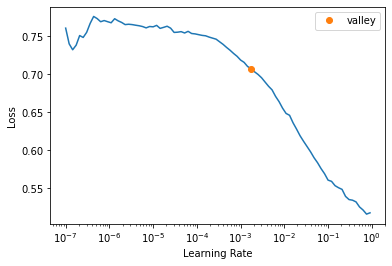

In [24]:
learn.lr_find()

In [25]:
learn.fit_one_cycle(2, lr_max=5e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,recall_score,precision_score,time
0,0.058896,0.033195,0.987855,0.012145,0.980351,0.962784,00:03
1,0.015995,0.015827,0.994076,0.005924,0.990175,0.981907,00:02


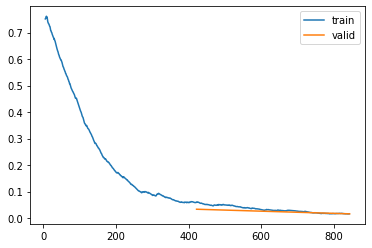

In [26]:
learn.recorder.plot_loss()

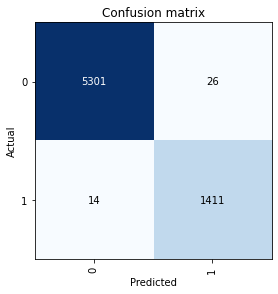

In [27]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [28]:
dl_test = pd.concat([all_set.X_test, all_set.y_test], axis=1)

In [40]:
to = learn.dls.train_ds.new(dl_test[:100])
to.process()
dl = TabDataLoader(to)

In [41]:
type(dl)

fastai.tabular.core.TabDataLoader

In [42]:
# !pip install fastinference[all]
import fastinference
from fastinference.tabular import *

In [43]:
exp = ShapInterpretation(learn, dl)

  0%|          | 0/100 [00:00<?, ?it/s]

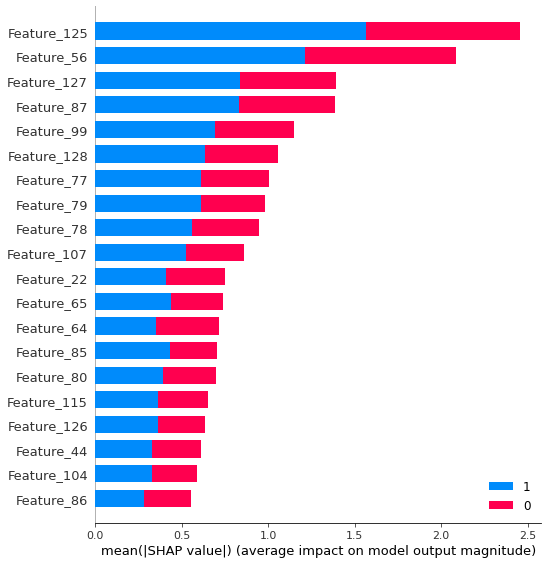

In [44]:
exp.summary_plot()

Classification model detected, displaying score for the class 1.
(use `class_id` to specify another class)
Displaying row 10 of 100 (use `row_idx` to specify another row)


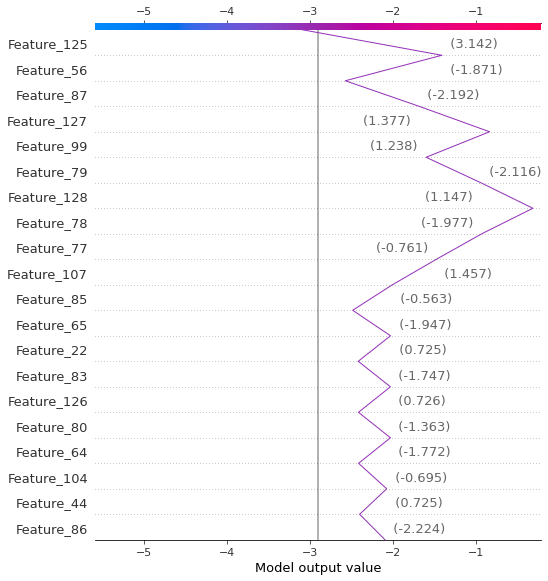

In [47]:
exp.decision_plot(class_id=1, row_idx=10)

In [51]:
to_a = learn.dls.train_ds.new(dl_test)
to_a.process()
dl_a = TabDataLoader(to_a)

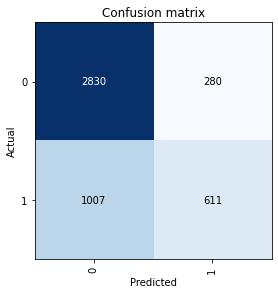

In [52]:
interp = ClassificationInterpretation.from_learner(learn, dl=dl_a)
interp.plot_confusion_matrix()

In [53]:
interp.print_classification_report()

              precision    recall  f1-score   support

           0       0.74      0.91      0.81      3110
           1       0.69      0.38      0.49      1618

    accuracy                           0.73      4728
   macro avg       0.71      0.64      0.65      4728
weighted avg       0.72      0.73      0.70      4728

